In [1]:
# from recsim import document
# from recsim import user
# from recsim.choice_model import MultinomialLogitChoiceModel
# 
# 

# import numpy as np
# from gym import spaces
# import matplotlib.pyplot as plt
# from scipy import stats

from recsim.simulator import environment
from recsim.simulator import recsim_gym

from movies_lib.samplers import MovieDocumentSampler
from movies_lib.samplers import MovieStaticUserSampler
from movies_lib.model import MovieUserModel
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from recsim.environments import interest_evolution
from recsim.agents import full_slate_q_agent
from recsim.simulator import runner_lib


2024-04-19 17:27:34.545782: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 17:27:34.979508: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
genres = ['Action', 'Adventure', 'Comedy', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']

#### Movies Sampler

In [3]:
# Create a sampler instance and sample documents
sampler = MovieDocumentSampler()
for i in range(5):
    print(sampler.sample_document())

Movie 0 with popularity 0.2618599474041827 and genre 1.
Movie 1 with popularity 1.5531511873632882 and genre 2.
Movie 2 with popularity 3.474132494033721 and genre 9.
Movie 3 with popularity 1.9104830451668364 and genre 8.
Movie 4 with popularity 1.9335715718820412 and genre 6.


#### Users Sampler

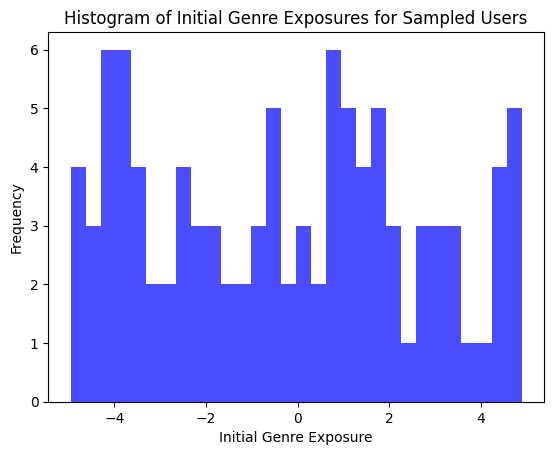

In [4]:
# Instantiate the MovieStaticUserSampler
sampler = MovieStaticUserSampler()
starting_genre_exposure = []

# Sample 1000 users and collect their initial genre exposures
for i in range(100):
    sampled_user = sampler.sample_user()
    starting_genre_exposure.append(sampled_user.net_genre_exposure)

# Plotting the histogram of starting genre exposures
_ = plt.hist(starting_genre_exposure, bins=30, color='blue', alpha=0.7)
plt.title("Histogram of Initial Genre Exposures for Sampled Users")
plt.xlabel("Initial Genre Exposure")
plt.ylabel("Frequency")
plt.show()

#### Recommendations Environment

In [5]:
slate_size = 3 # Number of items to recommend
num_candidates = 10 

# Initialize the environment for the movie recommendation system
movie_env = environment.Environment(
    MovieUserModel(slate_size),  # Use the adapted user model for movies
    MovieDocumentSampler(),     # Use the adapted document sampler for movies
    num_candidates,
    slate_size,
    resample_documents=True  # Enable resampling of documents for each step
)

Reward function

In [6]:
def movie_watched_rating_reward(responses):
    reward = 0.0
    for response in responses:
        if response.watched:
            reward += response.rating
    return reward

Final environment

In [7]:
movie_gym_env = recsim_gym.RecSimGymEnv(movie_env, movie_watched_rating_reward)

In [8]:
# Step 1: Reset the environment
# This initializes everything and returns the initial state of the environment.
# 'observation_0' contains the initial set of documents (movies) and the initial user state.
observation_0 = movie_gym_env.reset()
print('Observation 0: Initial environment state')
print('Available documents:')

# Extracting document details from the initial observation.
# This loop goes through each document provided in the initial observation,
# assuming that each document has properties such as 'id', 'genre', and 'popularity'.
doc_strings = [f"doc_id {doc_id}, genre {doc_details[1]}, popularity {doc_details[0]}" 
               for doc_id, doc_details in observation_0['doc'].items()]
print('\n'.join(doc_strings))  # Displaying document details

# Displaying the initial noisy user state observation
print('Noisy user state observation:')
print(observation_0['user'])

# Step 2: Make recommendations
# Here, we select the first three documents to recommend to the user.
# This is a simplistic approach for demonstration; in a real scenario, you might use
# a more sophisticated method to choose which documents to recommend.
recommendation_slate_0 = [0, 1, 2]
print('Making recommendations: Documents at indices 0, 1, 2')

# Step 3: Simulate the user's response to the recommended slate
# 'observation_1' is the new state of the environment after the user has interacted with the recommended documents.
# 'reward' captures the total reward from the user interactions (e.g., ratings),
# 'done' is a boolean indicating whether the simulation is over (e.g., user session ended),
# '_' can capture additional info, if any (commonly used to ignore additional outputs).
observation_1, reward, done, _ = movie_gym_env.step(recommendation_slate_0)

print('Observation 1: State after user interaction')
print('Available documents:')

# Extract and display document details from the new observation after interaction.
doc_strings = [f"doc_id {doc_id}, genre {doc_details[1]}, popularity {doc_details[0]}" 
               for doc_id, doc_details in observation_0['doc'].items()]
print('\n'.join(doc_strings))

# Display user responses to the recommended documents.
# We assume the 'response' objects can be meaningfully converted to string,
# which should provide details such as whether the movie was watched and what rating was given.
print('User responses to documents in the slate:')
rsp_strings = [str(response) for response in observation_1['response']]
print('\n'.join(rsp_strings))

# Display the updated noisy user state observation after interaction.
print('Noisy user state observation after interaction:')
print(observation_1['user'])

# Print reward received from the interactions and whether the simulation is done.
print(f'Received reward: {reward}')
print(f'Simulation done: {done}')


Observation 0: Initial environment state
Available documents:
doc_id 10, genre 5.0, popularity 0.9084765427223868
doc_id 11, genre 6.0, popularity 4.01531368911336
doc_id 12, genre 2.0, popularity 1.6043796764005318
doc_id 13, genre 7.0, popularity 4.639280537038523
doc_id 14, genre 6.0, popularity 3.5140367802941173
doc_id 15, genre 0.0, popularity 1.8244566944877922
doc_id 16, genre 5.0, popularity 0.9052548040608965
doc_id 17, genre 2.0, popularity 0.26855967588758856
doc_id 18, genre 4.0, popularity 1.3015580148944856
doc_id 19, genre 4.0, popularity 2.678914979497672
Noisy user state observation:
[0.64417171]
Making recommendations: Documents at indices 0, 1, 2
Observation 1: State after user interaction
Available documents:
doc_id 10, genre 5.0, popularity 0.9084765427223868
doc_id 11, genre 6.0, popularity 4.01531368911336
doc_id 12, genre 2.0, popularity 1.6043796764005318
doc_id 13, genre 7.0, popularity 4.639280537038523
doc_id 14, genre 6.0, popularity 3.5140367802941173
doc

### Gym test

In [9]:

def create_agent(sess, environment, eval_mode, summary_writer=None):
  kwargs = {
      'observation_space': environment.observation_space,
      'action_space': environment.action_space,
      'summary_writer': summary_writer,
      'eval_mode': eval_mode,
  }
  return full_slate_q_agent.FullSlateQAgent(sess, **kwargs)

In [10]:
slate_size = 5
num_candidates = 20
time_budget = 10 # Time budget for the user model, interactions per episode
# Initialize the environment for the movie recommendation system
movie_env = environment.Environment(
    MovieUserModel(slate_size,time_budget),  # Use the adapted user model for movies
    MovieDocumentSampler(),     # Use the adapted document sampler for movies
    num_candidates,
    slate_size,
    resample_documents=True  # Enable resampling of documents for each step
)

In [11]:
def movie_watched_rating_reward(responses):
    reward = 0.0
    for response in responses:
        if response.watched:
            reward += response.rating
    return reward

In [12]:
movie_gym_env = recsim_gym.RecSimGymEnv(movie_env, movie_watched_rating_reward)